# Maschinelles Lernen in der Bonitätsprüfung
## Seminararbeit Tobias Kuhlmann
Ziel ist eine Vorhersage der Kreditwürdigkeit von verschiedenen Bewerbungen. 

### Datensatz
https://archive.ics.uci.edu/ml/datasets/Statlog+(German+Credit+Data)
Abstract: This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix
Datensatzgröße ist 1000 Zeilen x (20 Attribute + 1 Klassifizierung)

### Ausführung
* Erst alle Funktionen am Anfang ausführen, die später die Klassifizierung übernehmen
* Nach den Funktionen beginnt der iterative Prozess: Preprocessing, train, evaluate

In [1]:
# @author Tobias Kuhlmann

# enable inline plotting with matplotbib and seaborn
%matplotlib inline

import numpy as np
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import pydotplus 

from IPython.display import Image  
from collections import defaultdict
from sklearn.dummy import DummyClassifier
from sklearn import svm, tree
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.feature_selection import RFE, SelectKBest, chi2, SelectFromModel
from sklearn.linear_model import LogisticRegression, SGDClassifier
from imblearn.over_sampling import SMOTE


## Algorithmen, Funktionen

* Cross Validation is performed with every Algorithm, if k-fold cross validation accuracy is significantly less than model accuracy, the model probably overfits

#### Function to get evaluation metrics and roc curve

In [2]:
# Function for evaluation reports
def get_eval(clf, X_train, y_train,y_test,y_pred):
    # Cross Validation to test and anticipate overfitting problem
    scores1 = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
    scores2 = cross_val_score(clf, X_train, y_train, cv=10, scoring='precision')
    scores3 = cross_val_score(clf, X_train, y_train, cv=10, scoring='roc_auc')
    # The mean score and standard deviation of the score estimate
    print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std()))
    print("Cross Validation Precision: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std()))
    print("Cross Validation roc_auc: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std()))
    # Create and print confusion matrix
    abclf_cm = confusion_matrix(y_test,y_pred)
    print(abclf_cm)
    return

# Function to get roc curve
def get_roc (y_test,y_pred):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    #Plot of a ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return

#### DecisionTreeClassifier

In [3]:
# fit, train and cross validate Decision Tree with training and test data 
def dectreeclf(X_train, y_train,X_test, y_test):
    print("DecisionTreeClassifier")
    dec_tree = tree.DecisionTreeClassifier(min_samples_split=10,min_samples_leaf=5).fit(X_train, y_train)

    # Predict target variables y for test data
    y_pred = dec_tree.predict(X_test)

    # Export visualization as file
    #visualize_tree(dec_tree,X_train,y_train)
    
    # Get Cross Validation and Confusion matrix
    get_eval(dec_tree, X_train, y_train,y_test,y_pred)
    return

# Visualize tree and save as .pdf
# Only works for dataframes, not for numpy arrays
def visualize_tree(clf,X_train,y_train):
    dot_data = export_graphviz(clf, out_file=None) 
    graph = pydotplus.graph_from_dot_data(dot_data) 
    graph.write_pdf("dectreeclf.pdf") 
     
        
    dot_data = export_graphviz(clf, out_file=None, 
                         feature_names=[str(x) for x in X_train.columns.tolist()], # feature names from X_train column names
                         class_names=[str(x) for x in clf.classes_],
                         filled=True, rounded=True,  
                         special_characters=True,
                         leaves_parallel=True)  
    graph = pydotplus.graph_from_dot_data(dot_data)  
    Image(graph.create_png()) 
    return

#### Random Forest Classifier

In [4]:
# fit, train and cross validate Decision Tree with training and test data 
def randomforestclf(X_train, y_train,X_test, y_test):
    print("RandomForestClassifier")
    randomforest = RandomForestClassifier().fit(X_train, y_train)

    # Predict target variables y for test data
    y_pred = randomforest.predict(X_test)

    # Get Cross Validation and Confusion matrix
    get_eval(randomforest, X_train, y_train,y_test,y_pred)
    return


#### Extra Tree Classifier

In [5]:
# fit, train and cross validate Decision Tree with training and test data 
def extratreesclf(X_train, y_train,X_test, y_test):
    print("ExtraTreesClassifier")
    extratrees = ExtraTreesClassifier().fit(X_train, y_train)

    # Predict target variables y for test data
    y_pred = extratrees.predict(X_test)

    # Get Cross Validation and Confusion matrix
    get_eval(extratrees, X_train, y_train,y_test,y_pred)
    return

#### GradientBoostingClassifier

In [6]:
# fit, train and cross validate GradientBoostingClassifier with training and test data 
def gradientboostingclf(X_train, y_train, X_test, y_test):  
    print("GradientBoostingClassifier")
    gbclf = GradientBoostingClassifier().fit(X_train, y_train)

    # Predict target variables y for test data
    y_pred = gbclf.predict(X_test)

    # Get Cross Validation and Confusion matrix
    get_eval(gbclf, X_train, y_train,y_test,y_pred)
    return

#### AdaBoostClassifier

In [7]:
# fit, train and cross validate GradientBoostingClassifier with training and test data 
def adaboostclf(X_train, y_train, X_test, y_test):  
    print("AdaBoostClassifier")
    abclf = AdaBoostClassifier().fit(X_train, y_train)

    # Predict target variables y for test data
    y_pred = abclf.predict(X_test)

    # Get Cross Validation and Confusion matrix
    get_eval(abclf, X_train, y_train,y_test,y_pred)
    return

#### Bagging Classifier

In [8]:
def baggingclf(X_train, y_train, X_test, y_test):  
    print("BaggingClassifier")
    bclf = BaggingClassifier().fit(X_train, y_train)

    # Predict target variables y for test data
    y_pred = bclf.predict(X_test)

    # Get Cross Validation and Confusion matrix
    get_eval(bclf, X_train, y_train,y_test,y_pred)
    return

#### Logistic Regression

In [9]:
# fit, train and cross validate Decision Tree with training and test data 
def logregclf(X_train, y_train,X_test, y_test):
    print("LogisticRegression")
    logreg = LogisticRegression().fit(X_train, y_train)

    # Predict target variables y for test data
    y_pred = logreg.predict(X_test)

    # Get Cross Validation and Confusion matrix
    get_eval(logreg, X_train, y_train,y_test,y_pred)
    return

#### SGDClassifier

In [10]:
# fit, train and cross validate Decision Tree with training and test data 
def sgdclf(X_train, y_train,X_test, y_test):
    print("SGDClassifier")
    sgd = SGDClassifier().fit(X_train, y_train)

    # Predict target variables y for test data
    y_pred = sgd.predict(X_test)

    # Get Cross Validation and Confusion matrix
    get_eval(sgd, X_train, y_train,y_test,y_pred)
    return

#### Linear SVC

In [11]:
# fit, train and cross validate linear Support Vector Machine with training and test data 
def linearsvmclf(X_train, y_train, X_test, y_test, C): 
    print("LinearSVC")
    lin_svc = svm.LinearSVC(C=C, class_weight="balanced",dual=False).fit(X_train, y_train)

    # Predict target variables y for test data
    y_pred = lin_svc.predict(X_test)
    
    # Get Cross Validation and Confusion matrix
    get_eval(lin_svc, X_train, y_train,y_test,y_pred)
    return

#### SVC

In [12]:
# fit, train and cross validate linear Support Vector Machine with training and test data 
def svmclf(X_train, y_train, X_test, y_test, C): 
    print("SVC")
    #C = 0.7  # SVM regularization parameter
    svc = svm.SVC(kernel='poly',degree=1,probability=True,C=C,class_weight="balanced").fit(X_train, y_train)

    # Predict target variables y for test data
    y_pred = svc.predict(X_test)
    
    # Get Cross Validation and Confusion matrix
    get_eval(svc, X_train, y_train,y_test,y_pred)
    return

#### Gaussian Naive Bayes

In [13]:
# fit, train and cross validate Gaussian Naive Bayes with training and test data 
def gaussnbclf(X_train, y_train, X_test, y_test):  
    print("GaussianNB")
    gauss_nb = GaussianNB().fit(X_train, y_train)

    # Predict target variables y for test data
    y_pred = gauss_nb.predict(X_test)

    # Get Cross Validation and Confusion matrix
    get_eval(gauss_nb, X_train, y_train,y_test,y_pred)
    return

#### KNeighborsClassifier

In [14]:
# fit, train and cross validate KNeighborsClassifier with training and test data 
def knnclf(X_train, y_train, X_test, y_test):  
    print("KNeighborsClassifier")
    knn = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)

    # Predict target variables y for test data
    y_pred = knn.predict(X_test)

    # Get Cross Validation and Confusion matrix
    get_eval(knn, X_train, y_train,y_test,y_pred)
    return

#### Neural Network: MLPClassifier

In [15]:
# fit, train and cross validate KNeighborsClassifier with training and test data 
# good working example with tensorflow https://github.com/andpol5/credit-classifier/blob/master/trainNeuralNet.py
# Choose hidden layer size: https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
def mlpclf(X_train, y_train, X_test, y_test): 
    print("MLPClassifier")
    # fit MLPClassifier with training data, good hidden_layer_sizes = 5,5:AUC63;75,75:AUC65;
    mlpclf = MLPClassifier(solver='lbfgs', alpha=5, hidden_layer_sizes=(75,75))
    mlpclf.fit(X_train, y_train)
    
    print(mlpclf.get_params)
    
    # Predict target variables y for test data
    y_pred = mlpclf.predict(X_test)
    
    # Get Cross Validation and Confusion matrix
    get_eval(mlpclf, X_train, y_train,y_test,y_pred)
    return

## Iterativer Prozess: Preprocess, train, evaluate

## Data preprocessing
* http://scikit-learn.org/stable/modules/preprocessing.html

### Data Summarization

#### Import  original categorical/numerical data

In [16]:
# import categorical/numerical data (.csv) with Pandas DataFrame
filename = '/Users/tobias/Documents/DS&RT Analytics/data/German credit/germancreditdata.data.csv'
names = ['existingchecking', 'duration', 'credithistory', 'purpose', 'creditamount', 
         'savings', 'employmentsince', 'installmentrate', 'statussex', 'otherdebtors', 
         'residencesince', 'property', 'age', 'otherinstallmentplans', 'housing', 
         'existingcredits', 'job', 'peopleliable', 'telephone', 'foreignworker', 'classification']
data = pd.read_csv(filename, delimiter=';', skiprows=1, names = names)
print(data.shape)
print (data.columns)
data.head(10)

(1000, 21)
Index(['existingchecking', 'duration', 'credithistory', 'purpose',
       'creditamount', 'savings', 'employmentsince', 'installmentrate',
       'statussex', 'otherdebtors', 'residencesince', 'property', 'age',
       'otherinstallmentplans', 'housing', 'existingcredits', 'job',
       'peopleliable', 'telephone', 'foreignworker', 'classification'],
      dtype='object')


,existingchecking,duration,credithistory,purpose,creditamount,savings,employmentsince,installmentrate,statussex,otherdebtors,...,property,age,otherinstallmentplans,housing,existingcredits,job,peopleliable,telephone,foreignworker,classification
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
5,A14,36,A32,A46,9055,A65,A73,2,A93,A101,...,A124,35,A143,A153,1,A172,2,A192,A201,1
6,A14,24,A32,A42,2835,A63,A75,3,A93,A101,...,A122,53,A143,A152,1,A173,1,A191,A201,1
7,A12,36,A32,A41,6948,A61,A73,2,A93,A101,...,A123,35,A143,A151,1,A174,1,A192,A201,1
8,A14,12,A32,A43,3059,A64,A74,2,A91,A101,...,A121,61,A143,A152,1,A172,1,A191,A201,1
9,A12,30,A34,A40,5234,A61,A71,4,A94,A101,...,A123,28,A143,A152,2,A174,1,A191,A201,2


In [17]:
#create quickaccess list with categorical variables labels
catvars = ['existingchecking', 'credithistory', 'purpose', 'savings', 'employmentsince',
           'statussex', 'otherdebtors', 'property', 'otherinstallmentplans', 'housing', 'job', 
           'telephone', 'foreignworker']
#create quickaccess list with numerical variables labels
numvars = ['creditamount', 'duration', 'installmentrate', 'residencesince', 'age', 
           'existingcredits', 'peopleliable', 'classification']

### Data Cleaning
####  Missing Values

In [18]:
print(data.isnull().sum().sum())
# No missing values

0


#### Outliers

In [19]:
# No outliers

In [20]:
# Binarize the y output for easier use of e.g. ROC curves -> 0 = 'bad' credit; 1 = 'good' credit
data.classification.replace([1,2], [1,0], inplace=True)
# Print number of 'good' credits (should be 700) and 'bad credits (should be 300)
data.classification.value_counts()

1    700
0    300
Name: classification, dtype: int64

#### Visualization

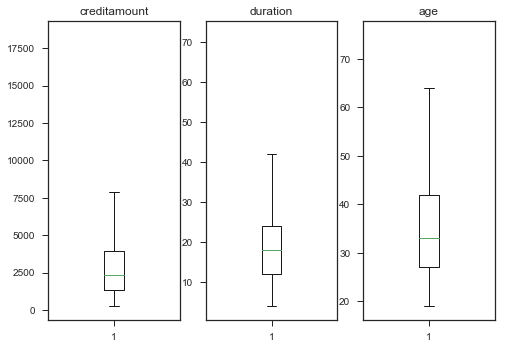

In [21]:
# Boxplots for continuous attributes
fig, axes = plt.subplots(nrows=1, ncols=3)
axes[0].boxplot(data['creditamount'])
axes[0].set_title('creditamount')
axes[1].boxplot(data['duration'])
axes[1].set_title('duration')
axes[2].boxplot(data['age'])
axes[2].set_title('age')

fig.savefig("boxplots.png")

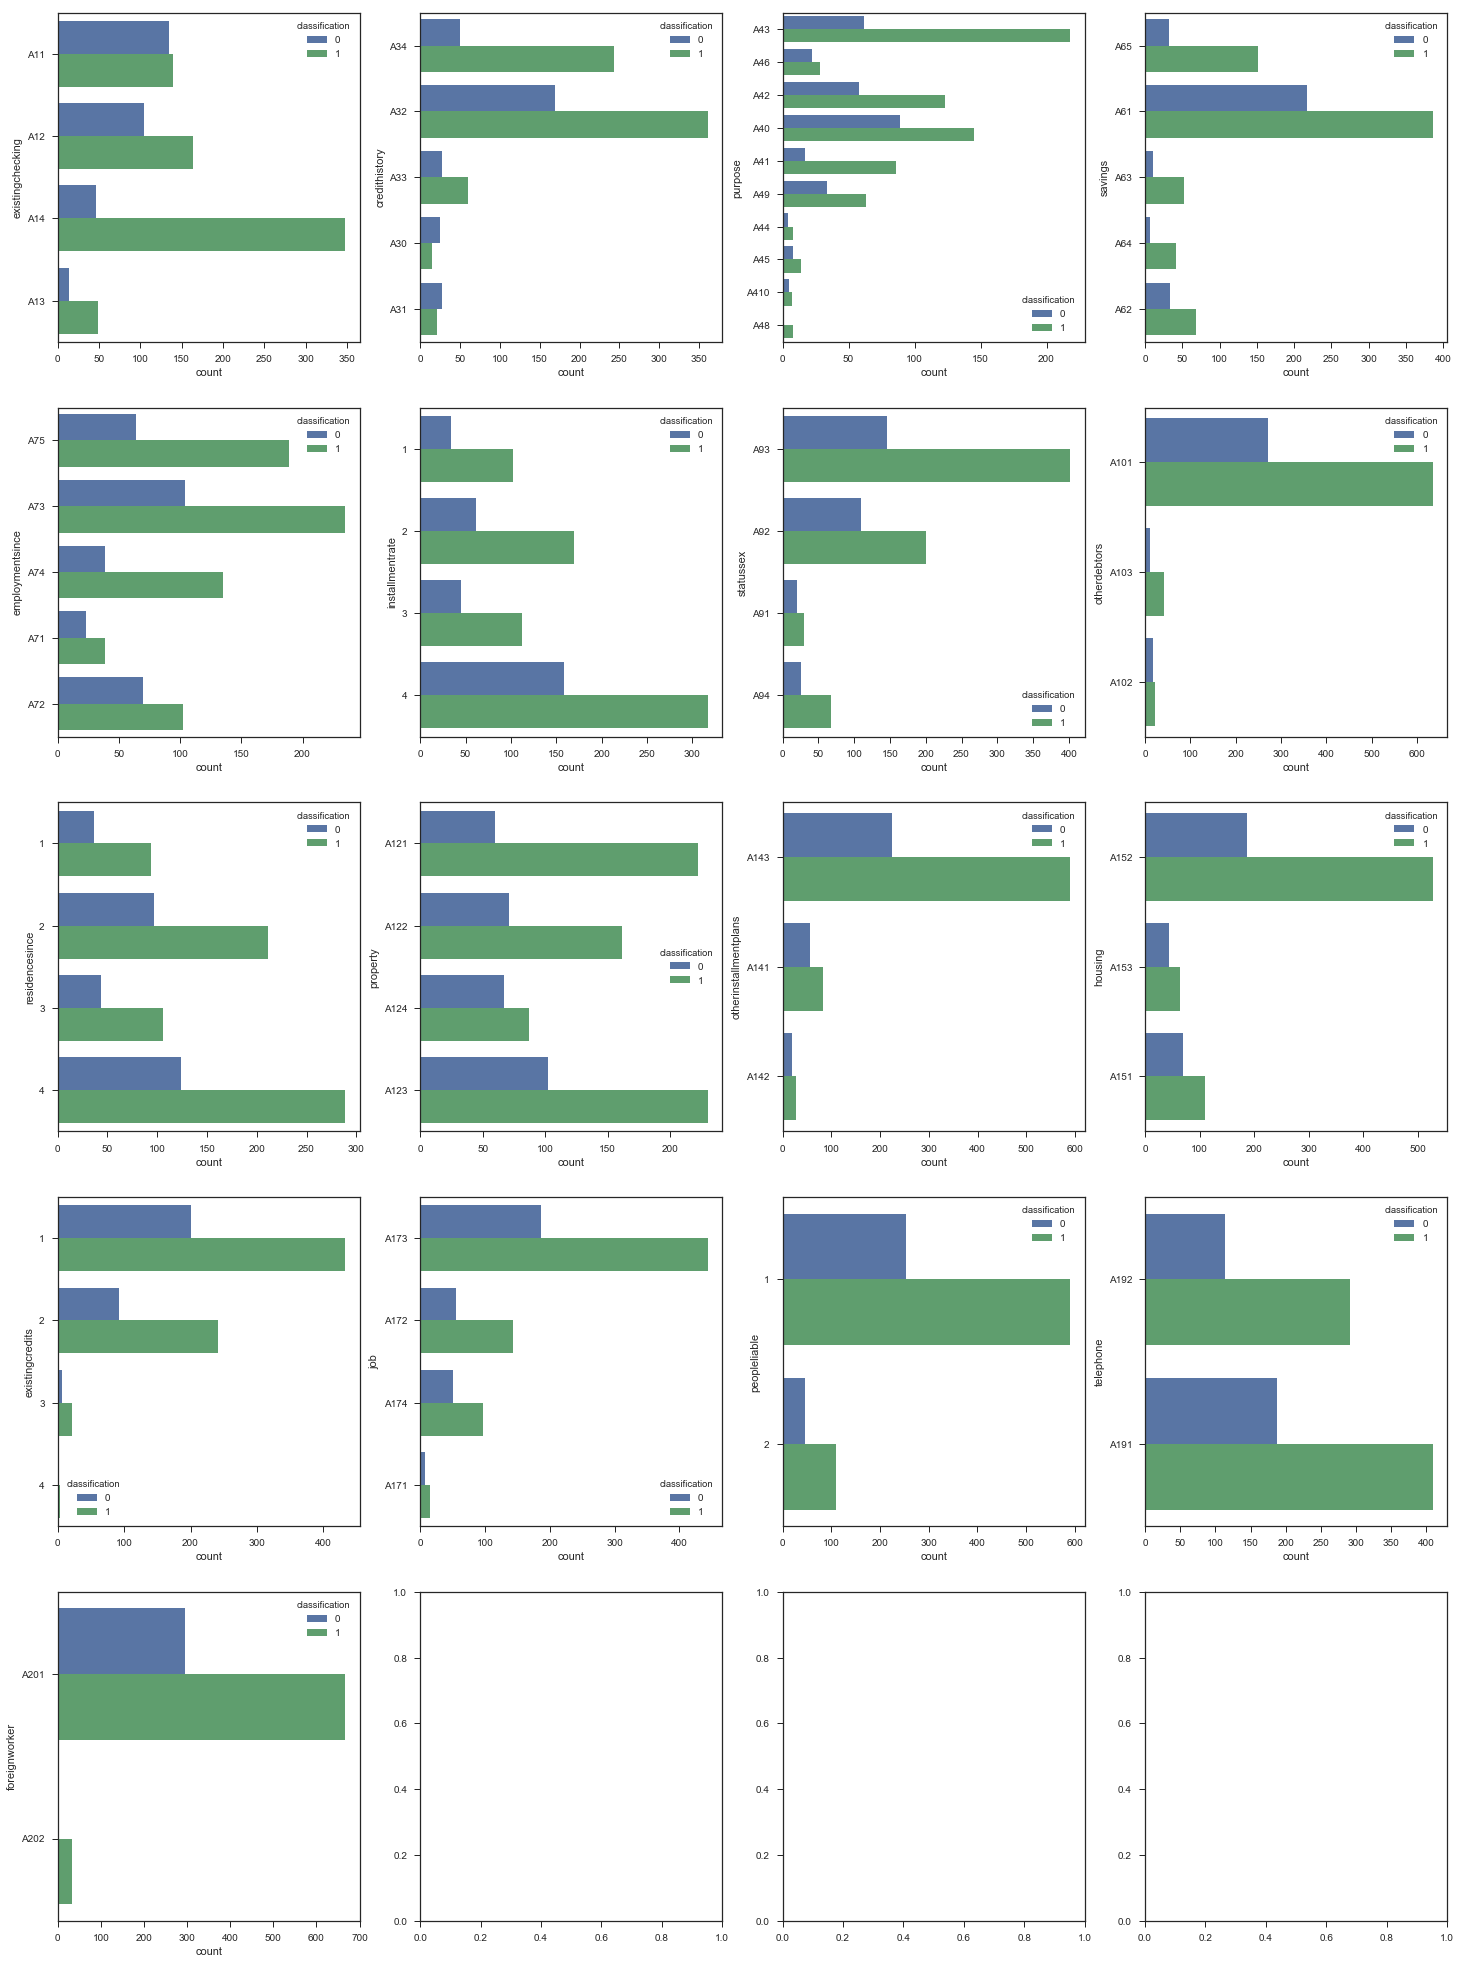

In [22]:
# Histograms for non-continuous attributes
f, axes = plt.subplots(5, 4,figsize=(8.3*3,11.7*3))
x=0
y=0
for column in data.drop(['classification','creditamount','duration','age'], axis=1):
    sns.countplot(y=column, hue="classification", data=data.drop(['creditamount','duration','age'],axis=1), ax=axes[x,y])
    y+=1
    if y>3:
        x+=1
        y=0
    if x>4:
        break
f.savefig("histograms5.png")

## Data Transformation
### Numerical features

In [23]:
# Numerical features range of values
for x in range(len(numvars)):
    print(numvars[x],": ", data[numvars[x]].min()," - ",data[numvars[x]].max())

creditamount :  250  -  18424
duration :  4  -  72
installmentrate :  1  -  4
residencesince :  1  -  4
age :  19  -  75
existingcredits :  1  -  4
peopleliable :  1  -  2
classification :  0  -  1


In [24]:
# Standardization
numdata_std = pd.DataFrame(StandardScaler().fit_transform(data[numvars].drop(['classification'], axis=1)))
# MinMax Rescaling to [0,1]
numdata_minmax = pd.DataFrame(MinMaxScaler().fit_transform(data[numvars].drop(['classification'], axis=1)))
print("success")

success


### Encoding categorical features 

In [25]:
# Labelencoding to transform categorical to numerical
# Enables better Visualization than one hot encoding
d = defaultdict(LabelEncoder)

# Encoding the variable
lecatdata = data[catvars].apply(lambda x: d[x.name].fit_transform(x))

# print transformations
for x in range(len(catvars)):
    print(catvars[x],": ", data[catvars[x]].unique())
    print(catvars[x],": ", lecatdata[catvars[x]].unique())

existingchecking :  ['A11' 'A12' 'A14' 'A13']
existingchecking :  [0 1 3 2]
credithistory :  ['A34' 'A32' 'A33' 'A30' 'A31']
credithistory :  [4 2 3 0 1]
purpose :  ['A43' 'A46' 'A42' 'A40' 'A41' 'A49' 'A44' 'A45' 'A410' 'A48']
purpose :  [4 7 3 0 1 9 5 6 2 8]
savings :  ['A65' 'A61' 'A63' 'A64' 'A62']
savings :  [4 0 2 3 1]
employmentsince :  ['A75' 'A73' 'A74' 'A71' 'A72']
employmentsince :  [4 2 3 0 1]
statussex :  ['A93' 'A92' 'A91' 'A94']
statussex :  [2 1 0 3]
otherdebtors :  ['A101' 'A103' 'A102']
otherdebtors :  [0 2 1]
property :  ['A121' 'A122' 'A124' 'A123']
property :  [0 1 3 2]
otherinstallmentplans :  ['A143' 'A141' 'A142']
otherinstallmentplans :  [2 0 1]
housing :  ['A152' 'A153' 'A151']
housing :  [1 2 0]
job :  ['A173' 'A172' 'A174' 'A171']
job :  [2 1 3 0]
telephone :  ['A192' 'A191']
telephone :  [1 0]
foreignworker :  ['A201' 'A202']
foreignworker :  [0 1]


In [26]:
# One hot encoding
#create dummy variables for every category of every categorical variable
dummyvars = pd.get_dummies(data[catvars])

#### Concat transformed datasets 

In [27]:
# append the dummy variable of the initial numerical variables numvars
data_clean = pd.concat([data[numvars], dummyvars], axis = 1)
data_std = pd.concat([numdata_std, data['classification'], dummyvars], axis = 1)
data_minmax = pd.concat([numdata_minmax, data['classification'], dummyvars], axis = 1)
print(data_clean.shape)
print(data_std.shape)
print(data_minmax.shape)

(1000, 62)
(1000, 62)
(1000, 62)


#### Split Training and Test Data

In [28]:
# Unscaled, unnormalized data
X_clean = data_clean.drop('classification', axis=1)
y_clean = data_clean['classification']
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean,y_clean,test_size=0.3333, random_state=1)

# Standardized data
X_std = data_std.drop('classification', axis=1)
y_std = data_std['classification']
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_std,y_std,test_size=0.3333, random_state=1)

# Rescaled data
X_minmax = data_minmax.drop('classification', axis=1)
y_minmax = data_minmax['classification']
X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax = train_test_split(X_minmax,y_minmax,test_size=0.3333, random_state=1)

#### Handle imbalanced data

* https://datascience.stackexchange.com/questions/1107/quick-guide-into-training-highly-imbalanced-data-sets
* https://datascience.stackexchange.com/questions/454/what-are-the-implications-for-training-a-tree-ensemble-with-highly-biased-datase
* http://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
* Use penalization in algorithms
* Set algorithm class weights
* Oversampling is done in data preprocessing

In [29]:
# Oversampling
# http://contrib.scikit-learn.org/imbalanced-learn/auto_examples/combine/plot_smote_enn.html#sphx-glr-auto-examples-combine-plot-smote-enn-py

# Apply SMOTE
sm = SMOTE(ratio='auto')
X_train_clean_res, y_train_clean_res = sm.fit_sample(X_train_clean, y_train_clean)
X_train_std_res, y_train_std_res = sm.fit_sample(X_train_std, y_train_std)
X_train_minmax_res, y_train_minmax_res = sm.fit_sample(X_train_minmax, y_train_minmax)

# Print number of 'good' credits and 'bad credits, should be fairly balanced now
print("Before/After clean")
unique, counts = np.unique(y_train_clean, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_train_clean_res, return_counts=True)
print(dict(zip(unique, counts)))
print("Before/After std")
unique, counts = np.unique(y_train_std, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_train_std_res, return_counts=True)
print(dict(zip(unique, counts)))
print("Before/After minmax")
unique, counts = np.unique(y_train_minmax, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_train_minmax_res, return_counts=True)
print(dict(zip(unique, counts)))

Before/After clean
{0: 208, 1: 458}
{0: 458, 1: 458}
Before/After std
{0: 208, 1: 458}
{0: 458, 1: 458}
Before/After minmax
{0: 208, 1: 458}
{0: 458, 1: 458}


## 1. Classification to evaluate data transformation

* Unbalanced data: Balance dataset, adjust cost function of algo, adjusting class weights
* General: adjust loss function

In [30]:
# Dummy Classifier
print("DummyClassifier")
dclf = DummyClassifier(strategy='stratified').fit(X_train_clean, y_train_clean)

# Predict target variables y for test data
y_pred = dclf.predict(X_test_clean)

# Get Cross Validation and Confusion matrix
get_eval(dclf, X_train_clean, y_train_clean,y_test_clean,y_pred)

DummyClassifier
Cross Validation Accuracy: 0.57 (+/- 0.05)
Cross Validation Precision: 0.68 (+/- 0.04)
Cross Validation roc_auc: 0.52 (+/- 0.05)
[[ 32  60]
 [ 78 164]]


In [31]:
# Decisiontree
# Train, test and evaluate the classifiers with different preprocessed data
print("clean resampled")
dectreeclf(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

clean resampled
DecisionTreeClassifier
Cross Validation Accuracy: 0.74 (+/- 0.10)
Cross Validation Precision: 0.77 (+/- 0.15)
Cross Validation roc_auc: 0.80 (+/- 0.12)
[[ 46  46]
 [ 57 185]]


In [32]:
# Logistic Regression
print("clean resampled")
logregclf(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

clean resampled
LogisticRegression
Cross Validation Accuracy: 0.78 (+/- 0.06)
Cross Validation Precision: 0.81 (+/- 0.06)
Cross Validation roc_auc: 0.83 (+/- 0.07)
[[ 59  33]
 [ 61 181]]


In [33]:
# Linear SVC with weighted classes (balanced)
print("std resampled")
linearsvmclf(X_train_std_res, y_train_std_res,X_test_std, y_test_std,2)

std resampled
LinearSVC
Cross Validation Accuracy: 0.76 (+/- 0.06)
Cross Validation Precision: 0.78 (+/- 0.05)
Cross Validation roc_auc: 0.82 (+/- 0.06)
[[ 61  31]
 [ 67 175]]


In [34]:
# SVC with weighted classes (balanced)
print('minmax resampled')
svmclf(X_train_minmax_res,y_train_minmax_res,X_test_minmax,y_test_minmax,2)

minmax resampled
SVC
Cross Validation Accuracy: 0.75 (+/- 0.06)
Cross Validation Precision: 0.78 (+/- 0.07)
Cross Validation roc_auc: 0.82 (+/- 0.06)
[[ 62  30]
 [ 62 180]]


In [35]:
# Gaussian Naive Bayes
# Train, test and evaluate the classifiers with different preprocessed data
print("clean resampled")
gaussnbclf(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

clean resampled
GaussianNB
Cross Validation Accuracy: 0.76 (+/- 0.06)
Cross Validation Precision: 0.80 (+/- 0.08)
Cross Validation roc_auc: 0.81 (+/- 0.06)
[[ 59  33]
 [ 74 168]]


### Data Reduction
#### Feature Selection
* http://scikit-learn.org/stable/modules/feature_selection.html

In [36]:
# Save Correlation Matrix of every variable
data_clean.corr(method='pearson').to_csv("data_corr.csv")

# List highly correlated features
c = data_clean.corr()
# Pivots the row/class labels with respective values: matrix -> list
s = c.stack()
# Select and sort (descending) all pairs with correlation values 0.5<x<1 or -1<x<-0.5
so = s[(0.5<s) & (s<1) | (-1<s) & (s<-0.5)].sort_values(ascending=False, kind='quicksort')
print(so)


property_A124               housing_A153                  0.779853
housing_A153                property_A124                 0.779853
creditamount                duration                      0.624984
duration                    creditamount                  0.624984
existingcredits             credithistory_A34             0.501364
credithistory_A34           existingcredits               0.501364
existingcredits             credithistory_A32            -0.540354
credithistory_A32           existingcredits              -0.540354
job_A173                    job_A174                     -0.543852
job_A174                    job_A173                     -0.543852
housing_A153                housing_A152                 -0.548445
housing_A152                housing_A153                 -0.548445
savings_A61                 savings_A65                  -0.583281
savings_A65                 savings_A61                  -0.583281
otherdebtors_A102           otherdebtors_A101            -0.64

In [37]:
# SelectKBest
# Use rescaled data, as data must be non-negative
skb = SelectKBest(chi2, k=50)
skb.fit(X_train_minmax_res, y_train_minmax_res)

# Apply fitted transformation to datasets
SKBX_train = skb.transform(X_train_clean_res)
SKBX_test = skb.transform(X_test_clean)
SKBy_train = y_train_minmax_res
SKBy_test = y_test_minmax

In [38]:
# Recursive feature elimination (RFE)
# Use clean data, as logistic regression should be robust do different feature scales
rfe = RFE(LogisticRegression(), 50)
fit = rfe.fit(X_train_clean_res, y_train_clean_res)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

# Apply fitted transformation to datasets
RFEX_train = rfe.transform(X_train_clean_res)
RFEX_test = rfe.transform(X_test_clean)
RFEy_train = y_train_clean_res
RFEy_test = y_test_clean

Num Features: 50
Selected Features: [False False  True False False  True  True  True  True  True  True  True
 False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False False False
 False  True False  True  True  True  True  True  True  True  True  True
  True]
Feature Ranking: [12  2  1  8 10  1  1  1  1  1  1  1  3  4  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  6 11  9  5  1
  7  1  1  1  1  1  1  1  1  1  1]


In [39]:
# Bagged Decision Trees like Random Forest and Extra Tree to determine feature importance
# Use clean data, unstandardized and unscaled, because tree is robust to different scales
etcclf = ExtraTreesClassifier().fit(X_train_clean_res, y_train_clean_res)
    
# Select important features using sklearn SelectFromModel, vary treshold, good value turns out to be mean -> select overaverage important features
sfm = SelectFromModel(etcclf, prefit=True, threshold=0.01)

# Apply fitted transformation to datasets
SFMETCX_train = sfm.transform(X_train_clean_res)
SFMETCX_test = sfm.transform(X_test_clean)
SFMETCy_train = y_train_clean_res
SFMETCy_test = y_test_clean

# Print shape to see how many features have been selected
print(SFMETCX_train.shape)

# Calculate the feature ranking - Top50 
importances = etcclf.feature_importances_ 
std = np.std([etcclf.feature_importances_ for tree in etcclf.estimators_], axis=0) 
indices = np.argsort(importances)[::-1] 
print("Top 50 Features:") 
for f in range(50): 
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]])) 
    

(916, 45)
Top 50 Features:
1. feature 7 (0.081420)
2. feature 10 (0.061386)
3. feature 15 (0.045450)
4. feature 0 (0.036200)
5. feature 8 (0.031297)
6. feature 1 (0.030455)
7. feature 2 (0.029471)
8. feature 43 (0.027182)
9. feature 3 (0.026099)
10. feature 4 (0.025329)
11. feature 16 (0.024719)
12. feature 26 (0.022429)
13. feature 37 (0.022318)
14. feature 30 (0.021087)
15. feature 38 (0.020698)
16. feature 55 (0.020237)
17. feature 20 (0.019956)
18. feature 51 (0.018813)
19. feature 49 (0.017617)
20. feature 17 (0.016430)
21. feature 44 (0.016059)
22. feature 13 (0.015978)
23. feature 33 (0.015690)
24. feature 5 (0.015577)
25. feature 50 (0.015415)
26. feature 32 (0.015172)
27. feature 46 (0.014979)
28. feature 45 (0.014736)
29. feature 40 (0.014542)
30. feature 58 (0.014176)
31. feature 57 (0.013035)
32. feature 35 (0.012715)
33. feature 47 (0.012648)
34. feature 6 (0.011932)
35. feature 42 (0.011719)
36. feature 34 (0.011694)
37. feature 56 (0.011678)
38. feature 19 (0.011557)
39.

In [40]:
# Principal Component Analysis
# Here we use standardized data, to not overestimate the influence of single variables, which results from different scaling
pca = PCA(n_components=10)
pca.fit_transform(X_train_std_res, y_train_std_res)
print(pca.explained_variance_ratio_) 

# Apply fitted transformation to datasets
PCAX_train = pca.transform(X_train_clean_res)
PCAX_test = pca.transform(X_test_clean)
PCAy_train = y_train_std_res
PCAy_test = y_test_std

[ 0.14632724  0.11604923  0.08376063  0.07194472  0.06671749  0.05777319
  0.03602018  0.03244407  0.02597071  0.02520787]


## 2. Classification to evaluate data reduction

In [41]:
# Logistic Regression
# clean res data and different data reduction
print("without reduction")
logregclf(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)
print("SKB")
logregclf(SKBX_train, SKBy_train, SKBX_test, SKBy_test)
print("RFE")
logregclf(RFEX_train, RFEy_train, RFEX_test, RFEy_test)
print("SFMETC")
logregclf(SFMETCX_train, SFMETCy_train, SFMETCX_test, SFMETCy_test)
print("PCA")
logregclf(PCAX_train, PCAy_train, PCAX_test, PCAy_test)

without reduction
LogisticRegression
Cross Validation Accuracy: 0.78 (+/- 0.05)
Cross Validation Precision: 0.80 (+/- 0.06)
Cross Validation roc_auc: 0.83 (+/- 0.07)
[[ 59  33]
 [ 60 182]]
SKB
LogisticRegression
Cross Validation Accuracy: 0.77 (+/- 0.06)
Cross Validation Precision: 0.79 (+/- 0.06)
Cross Validation roc_auc: 0.83 (+/- 0.07)
[[ 58  34]
 [ 64 178]]
RFE
LogisticRegression
Cross Validation Accuracy: 0.74 (+/- 0.05)
Cross Validation Precision: 0.75 (+/- 0.06)
Cross Validation roc_auc: 0.80 (+/- 0.06)
[[ 56  36]
 [ 62 180]]
SFMETC
LogisticRegression
Cross Validation Accuracy: 0.76 (+/- 0.07)
Cross Validation Precision: 0.79 (+/- 0.07)
Cross Validation roc_auc: 0.83 (+/- 0.07)
[[ 62  30]
 [ 67 175]]
PCA
LogisticRegression
Cross Validation Accuracy: 0.71 (+/- 0.07)
Cross Validation Precision: 0.71 (+/- 0.08)
Cross Validation roc_auc: 0.78 (+/- 0.07)
[[ 63  29]
 [ 68 174]]


In [42]:
#Gaussian Naive Bayes
# clean res data and different data reduction
print("without reduction")
gaussnbclf(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)
print("SKB")
gaussnbclf(SKBX_train, SKBy_train, SKBX_test, SKBy_test)
print("RFE")
gaussnbclf(RFEX_train, RFEy_train, RFEX_test, RFEy_test)
print("SFMETC")
gaussnbclf(SFMETCX_train, SFMETCy_train, SFMETCX_test, SFMETCy_test)
print("PCA")
gaussnbclf(PCAX_train, PCAy_train, PCAX_test, PCAy_test)

without reduction
GaussianNB
Cross Validation Accuracy: 0.76 (+/- 0.06)
Cross Validation Precision: 0.80 (+/- 0.08)
Cross Validation roc_auc: 0.81 (+/- 0.06)
[[ 59  33]
 [ 74 168]]
SKB
GaussianNB
Cross Validation Accuracy: 0.77 (+/- 0.06)
Cross Validation Precision: 0.80 (+/- 0.08)
Cross Validation roc_auc: 0.81 (+/- 0.06)
[[ 57  35]
 [ 69 173]]
RFE
GaussianNB
Cross Validation Accuracy: 0.73 (+/- 0.05)
Cross Validation Precision: 0.77 (+/- 0.06)
Cross Validation roc_auc: 0.78 (+/- 0.05)
[[ 57  35]
 [ 92 150]]
SFMETC
GaussianNB
Cross Validation Accuracy: 0.77 (+/- 0.06)
Cross Validation Precision: 0.79 (+/- 0.08)
Cross Validation roc_auc: 0.83 (+/- 0.06)
[[ 56  36]
 [ 54 188]]
PCA
GaussianNB
Cross Validation Accuracy: 0.55 (+/- 0.04)
Cross Validation Precision: 0.53 (+/- 0.03)
Cross Validation roc_auc: 0.58 (+/- 0.05)
[[ 27  65]
 [ 39 203]]


In [43]:
# SVC with weighted classes (balanced)
# minmax res data and different data reduction
print('without reduction')
svmclf(X_train_minmax_res,y_train_minmax_res,X_test_minmax,y_test_minmax,2)
print("SKB")
#svmclf(SKBX_train, SKBy_train, SKBX_test, SKBy_test,2)
print("RFE")
#svmclf(RFEX_train, RFEy_train, RFEX_test, RFEy_test,2)
print("SFMETC")
#svmclf(SFMETCX_train, SFMETCy_train, SFMETCX_test, SFMETCy_test,2)
print("PCA")
#svmclf(PCAX_train, PCAy_train, PCAX_test, PCAy_test,2)

without reduction
SVC
Cross Validation Accuracy: 0.75 (+/- 0.06)
Cross Validation Precision: 0.78 (+/- 0.07)
Cross Validation roc_auc: 0.82 (+/- 0.06)
[[ 62  30]
 [ 62 180]]
SKB
RFE
SFMETC
PCA


In [44]:
# Linear SVC with weighted classes (balanced)
print("without reduction")
linearsvmclf(X_train_std_res, y_train_std_res,X_test_std, y_test_std,2)
print("SKB")
linearsvmclf(SKBX_train, SKBy_train, SKBX_test, SKBy_test,2)
print("RFE")
linearsvmclf(RFEX_train, RFEy_train, RFEX_test, RFEy_test,2)
print("SFMETC")
linearsvmclf(SFMETCX_train, SFMETCy_train, SFMETCX_test, SFMETCy_test,2)
print("PCA")
linearsvmclf(PCAX_train, PCAy_train, PCAX_test, PCAy_test,2)

without reduction
LinearSVC
Cross Validation Accuracy: 0.76 (+/- 0.06)
Cross Validation Precision: 0.78 (+/- 0.05)
Cross Validation roc_auc: 0.82 (+/- 0.06)
[[ 61  31]
 [ 67 175]]
SKB
LinearSVC
Cross Validation Accuracy: 0.77 (+/- 0.06)
Cross Validation Precision: 0.80 (+/- 0.06)
Cross Validation roc_auc: 0.83 (+/- 0.07)
[[ 59  33]
 [ 65 177]]
RFE
LinearSVC
Cross Validation Accuracy: 0.74 (+/- 0.06)
Cross Validation Precision: 0.76 (+/- 0.07)
Cross Validation roc_auc: 0.80 (+/- 0.06)
[[ 56  36]
 [ 65 177]]
SFMETC
LinearSVC
Cross Validation Accuracy: 0.76 (+/- 0.06)
Cross Validation Precision: 0.79 (+/- 0.07)
Cross Validation roc_auc: 0.83 (+/- 0.06)
[[ 62  30]
 [ 70 172]]
PCA
LinearSVC
Cross Validation Accuracy: 0.70 (+/- 0.08)
Cross Validation Precision: 0.71 (+/- 0.08)
Cross Validation roc_auc: 0.78 (+/- 0.07)
[[ 63  29]
 [ 69 173]]


## 2. Increasing Accuracy

* Use bagging and boosting: RandomForestClassifier, ExtraTreesClassifier
* SVC, Grid Search Parameter Optimization
* Multilayer Perceptron Classifier
* Gradient Booster Classifier
* AdaBoost
* BaggingClassifier
* SGDClassifier
* VotingClassifier (Look where algorithms have their strengths - then combine e.g. good algo for tp with good algo for tp
* http://scikit-learn.org/stable/modules/ensemble.html


In [45]:
# Random Forest
# Choose clean data, as tree is robust
randomforestclf(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

RandomForestClassifier
Cross Validation Accuracy: 0.80 (+/- 0.09)
Cross Validation Precision: 0.83 (+/- 0.17)
Cross Validation roc_auc: 0.89 (+/- 0.12)
[[ 42  50]
 [ 50 192]]


In [46]:
# Extra Trees
# Choose clean data, as tree is robust
extratreesclf(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

ExtraTreesClassifier
Cross Validation Accuracy: 0.82 (+/- 0.07)
Cross Validation Precision: 0.86 (+/- 0.15)
Cross Validation roc_auc: 0.90 (+/- 0.10)
[[ 47  45]
 [ 41 201]]


In [47]:
# AdaBoostClassifier
# Choose clean data, as tree is robust
adaboostclf(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

AdaBoostClassifier
Cross Validation Accuracy: 0.80 (+/- 0.12)
Cross Validation Precision: 0.83 (+/- 0.17)
Cross Validation roc_auc: 0.88 (+/- 0.12)
[[ 45  47]
 [ 42 200]]


In [48]:
# BaggingClassifier
baggingclf(X_train_minmax_res, y_train_minmax_res, X_test_minmax, y_test_minmax)

BaggingClassifier
Cross Validation Accuracy: 0.78 (+/- 0.09)
Cross Validation Precision: 0.83 (+/- 0.14)
Cross Validation roc_auc: 0.87 (+/- 0.10)
[[ 43  49]
 [ 54 188]]


In [49]:
# GradientBoostingClassifier
# Choose clean data, as tree is robust
gradientboostingclf(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

GradientBoostingClassifier
Cross Validation Accuracy: 0.81 (+/- 0.12)
Cross Validation Precision: 0.83 (+/- 0.17)
Cross Validation roc_auc: 0.90 (+/- 0.10)
[[ 43  49]
 [ 31 211]]


In [50]:
# Multi-layer Perceptron classifier (MLP)
mlpclf(X_train_minmax, y_train_minmax, X_test_minmax, y_test_minmax)

MLPClassifier
<bound method BaseEstimator.get_params of MLPClassifier(activation='relu', alpha=5, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(75, 75), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)>
Cross Validation Accuracy: 0.70 (+/- 0.06)
Cross Validation Precision: 0.80 (+/- 0.04)
Cross Validation roc_auc: 0.76 (+/- 0.07)
[[ 42  50]
 [ 43 199]]


In [51]:
# SGDClassifier (Logistic Regression and SVC)
sgdclf(X_train_minmax, y_train_minmax, X_test_minmax, y_test_minmax)

SGDClassifier
Cross Validation Accuracy: 0.69 (+/- 0.05)
Cross Validation Precision: 0.82 (+/- 0.08)
Cross Validation roc_auc: 0.74 (+/- 0.08)
[[ 16  76]
 [  9 233]]
